In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

class AirplanesDataset(Dataset):
    def __init__(self, csv_file, img_dir, num_samples=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            num_samples (int, optional): Number of samples to take from the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.list_of_images = pd.read_csv(csv_file)
        self.images_directory = img_dir

        if num_samples is not None:
            self.list_of_images = self.list_of_images.head(num_samples)

        # If no transform is specified, we initialize it to resize and convert image to tensor
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.list_of_images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.images_directory, self.list_of_images.iloc[idx, 0])

      image = Image.open(image_path).convert("RGB")

      if self.transform:
          image = self.transform(image)

      bbox = np.array(self.list_of_images.iloc[idx, 1:5].values)
      bbox = bbox.astype(np.float32)
      bbox = torch.tensor(bbox, dtype=torch.float32)
      bbox = bbox.unsqueeze(0)

      return image, bbox


In [4]:
import torchvision.transforms as transforms

dataset_path = '/content/drive/MyDrive/Colab Notebooks/dl/airplanes-dataset'

csv_file_path = os.path.join(dataset_path, 'airplanes.csv')
image_directory = os.path.join(dataset_path, 'images')

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = AirplanesDataset(csv_file=csv_file_path, img_dir=image_directory, num_samples=100, transform=transformations)

image, target = dataset[0]
print(image.shape, target)

torch.Size([3, 224, 224]) tensor([[ 59.,  35., 342., 153.]])


In [36]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights

class BBoxRegressor(nn.Module):
    def __init__(self):
        super(BBoxRegressor, self).__init__()
        weights = ResNet50_Weights.DEFAULT
        backbone = resnet50(weights=weights)
        self.features = nn.Sequential(*list(backbone.children())[:-2])

        # Pooling para reducir las dimensiones antes de la regresión
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.bbox_head = nn.Conv2d(2048, 4, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)  # Aplicar pooling para reducir a [batch_size, 2048, 1, 1]
        bboxes = self.bbox_head(x)  # Esto ahora debería producir [batch_size, 4, 1, 1]
        return bboxes.view(x.size(0), 1, 4)  # Cambiar tamaño para coincidir con [batch_size, 1, 4]


In [7]:
!pip install torchinfo

In [37]:
from torchinfo import summary

input_size = (1, 3, 224, 224)  # Formato (batch_size, channels, height, width)

# Generar y mostrar el sumario del modelo
model_summary = summary(BBoxRegressor(), input_size=input_size)
print(model_summary)

Layer (type:depth-idx)                        Output Shape              Param #
BBoxRegressor                                 [1, 1, 4]                 --
├─Sequential: 1-1                             [1, 2048, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

In [43]:
import torch
import time
from torchvision.ops import generalized_box_iou_loss

def fit(model, train_loader, val_loader, epochs, optimizer, checkpoint_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)  # Assuming targets are already [batch_size, 4]

            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate IOU loss, and ensure it is reduced to a single scalar
            loss = generalized_box_iou_loss(outputs, targets)
            loss = loss.mean()  # Ensure the loss is a scalar by taking the mean

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            # Print loss every 10 batches
            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}, Batch {i + 1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}, Time: {time.time() - start_time:.2f}s')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                batch_loss = generalized_box_iou_loss(outputs, targets)
                batch_loss = batch_loss.mean()  # Ensure the loss is a scalar

                val_loss += batch_loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'New best model saved with avg_val_loss: {best_val_loss:.4f}')

    return avg_train_loss, avg_val_loss


In [44]:
from torch.utils.data import random_split

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Dataset size: {dataset_size}")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Dataset size: 100
Train size: 80
Validation size: 15
Test size: 5


In [45]:
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.ops import generalized_box_iou_loss

model = BBoxRegressor()
optimizer = optim.Adam(model.parameters(), lr=0.001)


checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/dl/airplanes_model/airplanes-regression-model"

train_losses, val_losses = fit(model, train_loader, val_loader, epochs=10, optimizer=optimizer, checkpoint_path=checkpoint_path)

Epoch 1, Average Training Loss: 1.3159, Time: 14.02s
Epoch 1, Average Validation Loss: -5.2191
New best model saved with avg_val_loss: -5.2191
Epoch 2, Average Training Loss: 1.1328, Time: 1.47s
Epoch 2, Average Validation Loss: 1.1264
Epoch 3, Average Training Loss: 0.3271, Time: 1.10s
Epoch 3, Average Validation Loss: 1.3221
Epoch 4, Average Training Loss: -2.1500, Time: 1.16s
Epoch 4, Average Validation Loss: -2457.0610
New best model saved with avg_val_loss: -2457.0610
Epoch 5, Average Training Loss: -6.6352, Time: 1.63s
Epoch 5, Average Validation Loss: -1806.8521
Epoch 6, Average Training Loss: -17.3368, Time: 1.12s
Epoch 6, Average Validation Loss: 1.3224
Epoch 7, Average Training Loss: -22.8788, Time: 1.11s
Epoch 7, Average Validation Loss: -2599.8606
New best model saved with avg_val_loss: -2599.8606
Epoch 8, Average Training Loss: -37.1962, Time: 1.48s
Epoch 8, Average Validation Loss: 1.3180
Epoch 9, Average Training Loss: -59.0236, Time: 1.15s
Epoch 9, Average Validation Lo

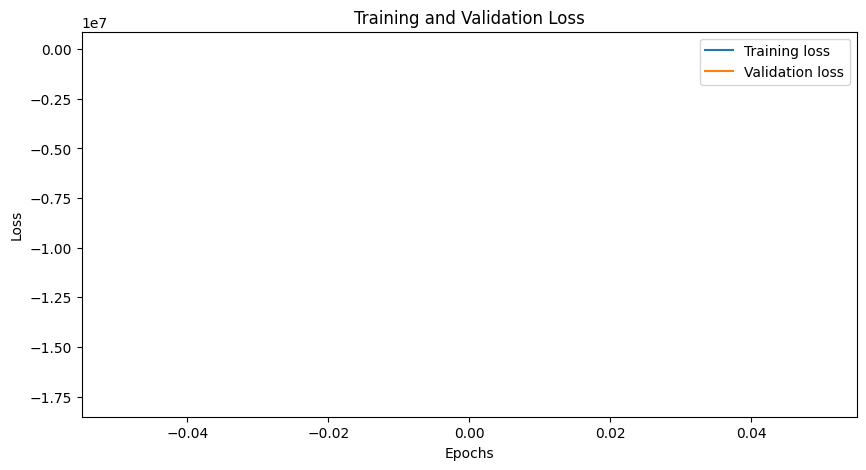

In [47]:
import matplotlib.pyplot as plt

# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [49]:
from torchvision import ops

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    ious = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            print(outputs.shape)
            print(targets.shape)

            for output, target in zip(outputs, targets):
                iou = ops.box_iou(output, target)
                ious.append(iou)

    avg_iou = sum(ious) / len(ious)
    return avg_iou


average_iou = test_model(model, test_loader)

print(f"Average IoU on Test Set: {average_iou.cpu().numpy()[0][0]}")

torch.Size([5, 1, 4])
torch.Size([5, 1, 4])
Average IoU on Test Set: 0.0
